In [2]:
import os
from dotenv import load_dotenv
from IPython.display import Markdown, display, update_display, Image
from openai import OpenAI
import google.generativeai as genai
import anthropic
import ollama
import gradio as gr

In [3]:
# Load environment variables in a file called .env

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", "your-key-if-not-using-env")
os.environ["ANTHROPIC_API_KEY"] = os.getenv(
    "ANTHROPIC_API_KEY", "your-key-if-not-using-env"
)
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY", "your-key-if-not-using-env")

In [4]:
system_message = "You are a helpful assistant that analyzes the content of an article and provides a summary in markdown."
prompt = "Please provide a short summary of the article in markdown format."

In [5]:
# Connect to OpenAI, Anthropic and Google

openai = OpenAI()

claude = anthropic.Anthropic()

genai.configure()

In [6]:
# Let's wrap a call to llama3.2 in a function
def summarize_llama(prompt):
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": prompt},
    ]
    response = ollama.chat(model="llama3.2", messages=messages)
    return response['message']['content']

In [7]:
# Let's wrap a call to GPT-4o-mini in a simple function

def summarize_gpt(prompt=prompt):
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": prompt},
    ]
    response = openai.chat.completions.create(
        model="gpt-4o-mini", messages=messages, stream=False
    )
    return response.choices[0].message.content

In [8]:
def summarize_claude(article_text):
    """
    Sends an article to the Anthropic API to generate a summary.
    
    Parameters:
    article_text (str): The full text of the article to be summarized.
    
    Returns:
    str: The summary of the article generated by the Anthropic API.
    """
    
    system_message = """
    You are an AI assistant tasked with summarizing articles. Your goal is to provide a concise, accurate, and informative summary of the key points in the given article text. Focus on capturing the main ideas, key findings, and important conclusions. Avoid including unnecessary details or tangents. The summary should be approximately 1-2 paragraphs in length.
    """
    
    try:
        response = claude.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=1000,
            system = system_message,
            messages = [
                {"role": "user", "content": article_text}
            ]
        )
        return response.content[0].text
    except Exception as e:
        raise Exception(f"Error summarizing article: {e}")

In [9]:
def gemini(prompt=prompt):
    gemini = genai.GenerativeModel(
    model_name='gemini-1.5-flash',
    system_instruction=system_message
    )
    response = gemini.generate_content(prompt)
    return response.candidates[0].content.parts[0].text

In [10]:
import pandas as pd

# Read a sample article from a CSV file
df = pd.read_csv("articles.csv")
df.head()

,article_id,full_text,ABSTRACT
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ..."
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...
3,PMC11240861,Research progress of DNA methylation in colore...,DNA methylation is one of the earliest and mos...
4,PMC11289611,"Investigating the Relationship of Serum CD163,...","Objective, This study aimed to compare serum l..."


In [11]:
# Select the first article
article = df["full_text"][0]
abstract = df["ABSTRACT"][0]

In [12]:
# Use Ollama to summarize the article
ollama_summary = summarize_llama(article)
print("Ollama Summary:")
display(Markdown(ollama_summary))

Ollama Summary:


This text outlines a comprehensive review of the relationship between melatonin and nicotine dependence. The authors aim to provide an overview of the current state of knowledge on this topic and identify future research directions to advance our understanding and improve treatment strategies.

**Key points:**

1. **The interplay between melatonin and nicotine dependence is complex**: The authors highlight the need for a multidisciplinary approach to understand the relationship between melatonin, the circadian system, and nicotine addiction.
2. **Current state of knowledge**: The review provides an overview of the current literature on the topic, including studies that have investigated the effects of melatonin on nicotine dependence, withdrawal symptoms, and cravings.
3. **Mechanisms underlying the interaction**: The authors discuss various mechanisms that may underlie the interaction between melatonin and nicotine dependence, including the regulation of the circadian system, neurotransmitter modulation, and inflammation.
4. **Future research directions**:
	* **Novel therapeutic targets**: Investigating novel therapeutic targets within the melatonergic system and circadian clock machinery could lead to the development of more specific and potent interventions for nicotine dependence.
	* **Digital health interventions**: Leveraging digital health technologies to enhance the delivery and accessibility of melatonin-based interventions for smoking cessation.
	* **Personalized treatment plans**: Developing personalized treatment plans that take into account individual differences in genetics, age, and circadian rhythms could lead to more effective treatment outcomes.

**Methodological limitations:**

1. **Limited search examining the melatonin-nicotine association**: The review highlights the need for further research on this topic, particularly in controlled laboratory settings or specific population groups.
2. **Longitudinal study designs**: Longitudinal studies are resource-intensive and may face challenges, such as participant attrition, loss of follow-up, and changes in smoking behavior during the study.
3. **Experimental manipulation**: Conducting experimental studies to investigate the effects of melatonin manipulation on nicotine dependence faces ethical and practical challenges.

**Conclusion:**

The authors conclude that further research is warranted to elucidate the precise mechanisms underlying the interaction between melatonin and nicotine dependence and to develop effective interventions for individuals with nicotine dependence. The interplay between melatonin and nicotine dependence involves complex neurobiological, physiological, and behavioral mechanisms, and a multidisciplinary approach is necessary to understand this association.

**Recommendations:**

1. **Interdisciplinary collaboration**: Encourage interdisciplinary collaboration among researchers from various fields, including psychology, neuroscience, pharmacology, and epidemiology.
2. **Standardized methods**: Develop standardized methods for measuring melatonin levels and nicotine dependence in humans, as well as animal models that can be used to investigate the effects of melatonin manipulation on nicotine addiction.
3. **Digital health technologies**: Explore the feasibility and effectiveness of digital health technologies, such as mobile applications and telemedicine platforms, in supporting adherence to melatonin supplementation and monitoring treatment outcomes remotely.

Overall, this review provides a comprehensive overview of the relationship between melatonin and nicotine dependence, highlighting the need for further research to advance our understanding and improve treatment strategies.

In [13]:
openai_response = summarize_gpt(article)
print("OpenAI Summary:")
display(Markdown(openai_response))

OpenAI Summary:


# Summary of the Review on Melatonin and Nicotine Dependence

## Introduction
Nicotine dependence is a significant public health issue characterized by compulsive cravings and dependence on nicotine, primarily due to tobacco products. Research into its mechanisms has struggled to yield effective prevention and cessation strategies. Recent studies have explored the relationship between nicotine dependence and melatonin, a neuroendocrine hormone.

## Nicotine Dependence
- **Definition**: A complex addiction involving compulsive behavior and physiological dependence on nicotine.
- **Impact**: Contributes to numerous health complications, including cardiovascular diseases, respiratory disorders, and cancer.
- **Mechanisms**: Nicotine activates reward pathways in the brain, notably the mesolimbic dopaminergic system, causing feelings of pleasure and reinforcing addictive behavior.

## Melatonin
- **Production**: Synthesized primarily at night by the pineal gland, regulating circadian rhythms.
- **Role**: Beyond sleep regulation, melatonin has antioxidant, immunomodulatory, and neuroprotective properties.
- **Receptors**: Present throughout the brain, including areas involved in addiction; they may influence dopamine release and modulate nicotine-seeking behaviors.

## Melatonin's Influence on Nicotine Dependence
### Physiological Roles
- Antioxidant functions may protect against nicotine-induced oxidative stress.
- Modulation of mood and stress responses may affect susceptibility to addiction.

### Circadian Rhythms and Nicotine Cravings
- Cravings often exhibit diurnal variations, with higher cravings noted during nicotine deprivation.
- Circadian disruptions (e.g., from shift work) can exacerbate cravings, suggesting potential benefits of melatonin supplementation.

### Withdrawal Symptoms
- Melatonin may alleviate withdrawal symptoms, such as anxiety and cravings, during smoking cessation.
- Clinical trials have shown promising results, with melatonin improving sleep quality and reducing irritability and cravings.

## Potential Therapeutic Implications
1. **Melatonin Supplementation**: May mitigate withdrawal effects and support smoking cessation.
2. **Receptor Agonists**: Targeted interventions can provide more potent effects than supplements alone.
3. **Combination Therapies**: Integrating melatonin with existing cessation treatments (like NRT) can enhance outcomes.
4. **Behavioral Therapies**: Melatonin-based approaches paired with CBT may address behavioral components of dependence.

## Gaps in Research
- Need for more studies to clarify the mechanisms through which melatonin affects nicotine dependence.
- Exploration of individual variations in response to melatonin, influenced by genetics, age, sex, and comorbid conditions.

## Methodological Challenges
- Difficulty in measuring melatonin levels accurately.
- Issues with quantifying nicotine exposure and accounting for numerous confounders.
- Challenges in designing robust long-term studies to assess the impact of melatonin on nicotine dependence.

## Future Directions
- Identify novel therapeutic targets within the melatonergic system for more tailored interventions.
- Explore the use of digital health technologies to enhance adherence and monitor treatment effectiveness.

## Conclusion
The interplay between melatonin and nicotine dependence is complex, involving various neurobiological and behavioral factors. Further research is essential to understand this relationship better and develop effective treatment strategies for nicotine addiction.

In [14]:
# Use the Anthropic API to summarize the article
anthropic_response = summarize_claude(article)
print("Anthropic Summary:")
display(Markdown(anthropic_response))

Anthropic Summary:


Here is a summary of the key points from the article:

The article explores the potential association between the neuroendocrine hormone melatonin and nicotine dependence. Nicotine addiction is a major public health challenge, contributing to various health consequences including cardiovascular disease, respiratory disorders, and cancer. 

Melatonin is known to play a crucial role in regulating circadian rhythms and sleep-wake cycles. Emerging evidence suggests that melatonin may also modulate the reward pathways and neurotransmitter systems implicated in addiction, including the dopaminergic, glutamatergic, GABAergic, and serotonergic systems.

The article discusses how disruptions in circadian rhythms and melatonin secretion may increase vulnerability to nicotine dependence. Preclinical and clinical studies indicate that melatonin supplementation could help mitigate nicotine withdrawal symptoms and cravings during smoking cessation attempts. 

Factors such as genetics, age, sex, and comorbidities can influence the effectiveness of melatonin-based interventions for nicotine dependence. Personalized treatment approaches accounting for individual differences may optimize the efficacy of these interventions.

The article also highlights methodological challenges in studying the melatonin-nicotine association, including accurately measuring melatonin levels and nicotine exposure, accounting for circadian rhythms, and conducting longitudinal studies. Further research is needed to elucidate the mechanisms underlying this association and develop effective therapeutic strategies targeting melatonin for treating nicotine addiction.

In [15]:
# Use the Google Generative AI API to summarize the article
gemini_response = gemini(article)
print("Gemini Summary:")
display(Markdown(gemini_response))

Gemini Summary:


# Melatonin and Nicotine Dependence: A Review

This review explores the association between melatonin, a hormone regulating circadian rhythms, and nicotine dependence.  Nicotine addiction, a significant public health issue, involves activation of the brain's reward pathways.  Melatonin, produced primarily at night by the pineal gland, has diverse physiological roles beyond sleep regulation, including antioxidant, immunomodulatory, and neuroprotective effects.

**Melatonin's multifaceted roles:** The review details melatonin's synthesis, its role in synchronizing circadian rhythms, its antioxidant and immunomodulatory properties, and its neuroprotective effects.  It also touches upon melatonin's influence on reproductive function.

**Nicotine dependence and its health consequences:** The review describes the mechanisms of nicotine addiction, including its effects on the brain's reward pathways and neuroadaptations.  It details the wide-ranging health consequences of nicotine dependence, focusing on cardiovascular effects, respiratory complications, cancer risk, and mental health effects.

**Melatonin receptors and their distribution:** The review explains the two main melatonin receptor types (MT1 and MT2) and their distribution throughout the brain, emphasizing their roles in circadian regulation, sleep-wake cycles, mood modulation, and neuroprotection.

**Melatonin's influence on neurotransmitter systems:** Melatonin's influence on neurotransmitter systems implicated in addiction (dopaminergic, glutamatergic, GABAergic, serotonergic, and endogenous opioid systems) is discussed, highlighting its potential to modulate reward processing and reduce drug-seeking behavior.

**Circadian rhythms and nicotine cravings:** The review explores the interplay between melatonin-regulated circadian rhythms and nicotine cravings, noting that circadian disruptions can exacerbate cravings and increase addiction vulnerability.  Chronotherapeutic approaches targeting circadian rhythms and melatonin signaling are proposed as potential treatments.

**Melatonin's role in mitigating withdrawal symptoms:** Preclinical and clinical studies suggest melatonin may alleviate nicotine withdrawal symptoms, including cravings, irritability, and sleep disturbances.  Melatonin supplementation during smoking cessation shows promise in improving outcomes.

**Potential therapeutic interventions:** The review discusses potential therapeutic interventions targeting melatonin for nicotine dependence, including melatonin supplementation, melatonin receptor agonists, combined therapies (with existing pharmacotherapies or behavioral therapies), light therapy, and lifestyle modifications.

**Methodological challenges and future research:** The review highlights several methodological challenges in studying the melatonin-nicotine association, such as measuring melatonin levels accurately, assessing nicotine exposure, accounting for circadian rhythms, and controlling confounding variables.  Future research directions include identifying novel therapeutic targets, developing digital health interventions, and conducting large-scale longitudinal studies to clarify the mechanisms and optimize treatment strategies.  The review also emphasizes the need for personalized treatment approaches based on individual differences in melatonin responsiveness, circadian rhythms, genetic variations, age, sex, comorbid conditions, and lifestyle factors.


In [16]:
import evaluate
rouge = evaluate.load("rouge")

## Evaluate the summaries generated by the different models

In [17]:
ollama_scores = rouge.compute(predictions=[ollama_summary], references=[abstract])
print("Ollama Scores:")
print(ollama_scores)

Ollama Scores:
{'rouge1': 0.37350993377483444, 'rouge2': 0.07702523240371846, 'rougeL': 0.18543046357615894, 'rougeLsum': 0.2410596026490066}


In [18]:
openai_scores = rouge.compute(predictions=[openai_response], references=[abstract])
print("OpenAI gemini-1.5-flash Scores:")
print(openai_scores)

OpenAI gemini-1.5-flash Scores:
{'rouge1': 0.49019607843137253, 'rouge2': 0.1292134831460674, 'rougeL': 0.22969187675070027, 'rougeLsum': 0.3333333333333333}


In [19]:
anthropic_scores = rouge.compute(predictions=[anthropic_response], references=[abstract])
print("Anthropic Scores:")
print(anthropic_scores)

Anthropic Scores:
{'rouge1': 0.5101214574898785, 'rouge2': 0.15447154471544716, 'rougeL': 0.2469635627530364, 'rougeLsum': 0.3076923076923077}


In [20]:
genai_scores = rouge.compute(predictions=[gemini_response], references=[abstract])
print("Google Generative AI Scores:")
print(genai_scores)

Google Generative AI Scores:
{'rouge1': 0.48710601719197705, 'rouge2': 0.14942528735632188, 'rougeL': 0.24641833810888247, 'rougeLsum': 0.3065902578796562}


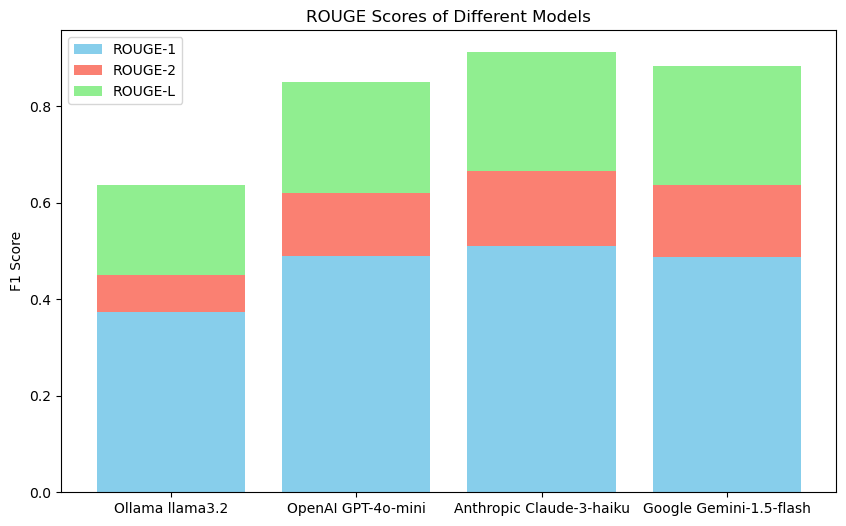

In [21]:
# Create a chart to compare the ROUGE scores of the different models

import matplotlib.pyplot as plt

models = [
    "Ollama llama3.2",
    "OpenAI GPT-4o-mini",
    "Anthropic Claude-3-haiku",
    "Google Gemini-1.5-flash",
]

rouge_1_scores = [
    ollama_scores["rouge1"],
    openai_scores["rouge1"],
    anthropic_scores["rouge1"],
    genai_scores["rouge1"],
]
rouge_2_scores = [
    ollama_scores["rouge2"],
    openai_scores["rouge2"],
    anthropic_scores["rouge2"],
    genai_scores["rouge2"],
]
rouge_l_scores = [
    ollama_scores["rougeL"],
    openai_scores["rougeL"],
    anthropic_scores["rougeL"],
    genai_scores["rougeL"],
]

plt.figure(figsize=(10, 6))

# Stack the bars using variable names for scores
plt.bar(models, rouge_1_scores, color="skyblue", label="ROUGE-1")
plt.bar(models, rouge_2_scores, bottom=rouge_1_scores, color="salmon", label="ROUGE-2")
plt.bar(
    models,
    rouge_l_scores,
    bottom=[i + j for i, j in zip(rouge_1_scores, rouge_2_scores)],
    color="lightgreen",
    label="ROUGE-L",
)

plt.ylabel("F1 Score")
plt.title("ROUGE Scores of Different Models")
plt.legend()
plt.show()

In [22]:
# Create a Gradio interface to summarize articles using the different models

def summarize_article(prompt, model):
    if model == "Ollama":
        return summarize_llama(prompt)
    elif model == "GPT":
        return summarize_gpt(prompt)
    elif model == "Claude":
        return summarize_claude(prompt)
    elif model == "Gemini":
        return gemini(prompt)

In [28]:
view = gr.Interface(
    fn=summarize_article,
    inputs=[
        gr.Textbox(label="Your article:"),
        gr.Dropdown(["Ollama","GPT", "Claude", "Gemini"], label="Select model", value="Ollama"),
    ],
    outputs=[gr.Markdown(label="Summary")],
    flagging_mode="never",
    description="Summarize an article using different models.",
)

view.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2024/11/18 08:56:34 [W] [service.go:132] login to server failed: read tcp 172.16.16.2:64269->44.237.78.176:7000: read: connection reset by peer


## Gradio example input output

In [33]:
Image(url="Gradio_Screenshot.jpg")

### RAG
RAG (Retrieval Augmented Generation) is a technique that enhances the ability of large language models (LLMs) by retrieving relevant information from an external knowledge base and including it in the prompt. This allows the LLM to generate more informed and accurate responses.

Using RAG with an article abstracts should enhance the quality and efficiency of text summarization. It's a great way to leverage existing knowledge and guide the LLM towards generating more accurate and informative summaries.

In [23]:
def summarize_claude_rag(article_text, abstract):
    """
    Sends an article to the Anthropic API to generate a summary, 
    augmented with the article's abstract for improved context.
    
    Parameters:
    article_text (str): The full text of the article to be summarized.
    abstract (str): The abstract of the article.

    Returns:
    str: The summary of the article generated by the Anthropic API.
    """
    
    system_message = """
    You are an AI assistant tasked with summarizing articles. 
    You will be provided with the article's abstract and full text.
    Use the abstract to gain a high-level understanding of the article. 
    Then, based on the full text, provide a concise, accurate, and informative summary of the key points. 
    Focus on capturing the main ideas, key findings, and important conclusions. 
    Avoid including unnecessary details or tangents. 
    The summary should be approximately 1-2 paragraphs in length.
    """
    
    try:
        response = claude.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=1000,
            system = system_message,
            messages = [
                {"role": "user", "content": f"Abstract: {abstract}\n\nArticle Text: {article_text}"}
            ]
        )
        return response.content[0].text
    except Exception as e:
        raise Exception(f"Error summarizing article: {e}")

In [24]:
# summarize the article using the augmented function
claude_rag_response = summarize_claude_rag(article, abstract)

# display the augmented summary
print("Claude RAG Summary:")
display(Markdown(claude_rag_response))

Claude RAG Summary:


Here is a summary of the key points from the article:

The article explores the potential association between melatonin, the "hormone of darkness", and nicotine dependence. Nicotine dependence is a serious global public health concern due to the highly addictive nature of tobacco products. Emerging evidence suggests that melatonin, which regulates circadian rhythms and has neuroprotective effects, may play a role in modulating nicotine-seeking behavior and withdrawal symptoms.

Melatonin receptors are widely distributed throughout the brain, including areas involved in the reward pathway and addiction-related behaviors. Preclinical studies indicate that melatonin may attenuate the reinforcing effects of nicotine by influencing dopaminergic, glutamatergic, GABAergic and serotonergic neurotransmission. Additionally, melatonin's antioxidant properties may mitigate the oxidative stress induced by chronic nicotine exposure.

The article also discusses the potential therapeutic implications of targeting melatonin signaling for smoking cessation. Melatonin supplementation may help alleviate nicotine withdrawal symptoms, such as craving, irritability and sleep disturbances. Chronotherapeutic approaches, including timed melatonin administration or light therapy, show promise in regulating circadian rhythms and reducing nicotine cravings.

However, the article also highlights several gaps in current knowledge, including the need to elucidate the precise molecular mechanisms underlying the melatonin-nicotine association, and the importance of considering individual differences in melatonin responsiveness, genetics, age, sex and comorbidities when developing personalized treatment strategies. Further research is required to optimize the integration of melatonin-based interventions into smoking cessation protocols and to address the methodological challenges in studying this complex relationship.

In [27]:
# evaluate the augmented summary using ROUGE
claude_rag_scores = rouge.compute(predictions=[claude_rag_response], references=[abstract])
print("Claude(anthropic) Score:")
print(anthropic_scores)
print()
print("Claude RAG Scores:")
print(claude_rag_scores)

Claude(anthropic) Score:
{'rouge1': 0.5101214574898785, 'rouge2': 0.15447154471544716, 'rougeL': 0.2469635627530364, 'rougeLsum': 0.3076923076923077}

Claude RAG Scores:
{'rouge1': 0.6026365348399247, 'rouge2': 0.26465028355387527, 'rougeL': 0.29378531073446323, 'rougeLsum': 0.3050847457627119}


The ROUGE scores above show a noticeable improvement when using RAG with Claude:

- ROUGE-1: Increased by approximately 9 percentage points (from 0.51 to 0.60). This indicates a significant improvement in capturing individual words and phrases present in the reference summary.
- ROUGE-2: Increased by about 11 percentage points (from 0.15 to 0.26). This is a substantial jump, suggesting the RAG-augmented summary is much better at capturing the relationships between pairs of words, reflecting an improved understanding of the text.
- ROUGE-L and ROUGE-Lsum: Showed smaller increases (around 4-5 percentage points). These metrics consider the longest common subsequences, indicating that while the overall structure might not have changed drastically, the content within that structure is more accurate.

 It’s safe to say that incorporating RAG with Claude, and by extension, other LLM models, results in a notable improvement in summarization quality. This underscores the significance of contextualizing large language models for enhanced performance.

## To do: Fine-tuning LLM for our use case